In [97]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import numpy as np
import math
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = '{:,}'.format


In [98]:
# FUNCTIONS

def enum_category(label):
    num=0
    if label == 'Poor' : num =1
    elif label == 'Fair': num = 2
    elif label == 'Average': num = 3
    elif label == 'Good': num = 4
    elif label == 'Very Good': num = 5
    else: return label
    
    return int(num)

def log_and_normalize (data, log, norm_type):
    if log == 'log':
        data = np.log(data) 
    if norm_type == 1:
        data = (data-np.mean(data))/np.std(data)  # std normalisation
    elif norm_type == 2:
        data = (data-min(data))/(max(data)-min(data))      #  min_max_min
    elif norm_type == 3:
        data = (data-np.mean(data))/(max(data)-min(data))  # mean norm
    
    return data    

def hot_encode (data, directions):
    if directions == 'yes':
        data = pd.get_dummies(data, prefix=data.name[:3], drop_first=True)
    return data

In [99]:
df=pd.read_csv('data/kc_house_data.csv', index_col=0)

# initial cleaning operations (splitting , etc)

df["grade"]=df["grade"].map(lambda x: x.split()[0]).astype(int)
df['condition'] = df['condition'].apply(enum_category)


In [174]:
# Prepairing data

df['yr_renovated'].fillna(value=df['yr_built'],inplace=True)
df['yr_renovated'] = np.where(df['yr_renovated'] == 0, df['yr_built'], df['yr_renovated'])

df['waterfront'].fillna(value='NO',inplace=True)

#NEW FEATURES

df['lat_range']=pd.cut(df['lat'], 30)
df['long_range']=pd.cut(df['long'], 30)
df['coord_range']=np.array(zip(df['lat_range'],df['long_range']))
df['decade']=pd.cut(df['yr_built'], 12)

#FILTER
#df=df[df['yr_built']>1980]

In [175]:
data_fin=pd.DataFrame([])

price=df[["price"]]

#cont=["sqft_living", 'sqft_lot', 'sqft_living15']

cont=["sqft_living"]
cat=[ 'grade', 'zipcode', 'view', 'waterfront','yr_built']


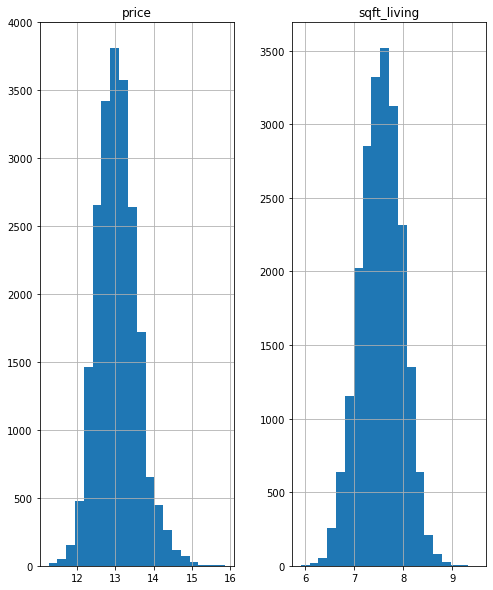

In [176]:
# Log transform and normalize
price=log_and_normalize(price, 'log', 0)
for col in cont:
    data_fin[col]=log_and_normalize(df[col], 'log', 0)


pd.concat([price, data_fin], axis=1).hist(figsize=(8,10), bins=20);


In [177]:
# One hot encode categoricals
for col in cat:
    new_cols=hot_encode(df[col], 'yes')
    data_fin = pd.concat([data_fin, new_cols], axis=1)

data_fin = pd.concat([price, data_fin], axis=1)

In [178]:
# Create OLS linear model
pred=data_fin.drop(columns=["price"]).copy()

pred_int = sm.add_constant(pred)
model = sm.OLS(price,pred_int).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     740.1
Date:                Sat, 26 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:02:55   Log-Likelihood:                 5551.5
No. Observations:               21597   AIC:                        -1.070e+04
Df Residuals:                   21396   BIC:                            -9097.
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.4504      0.193     48.868      0.000       9.071       9.829
sqft_living       0.4903      0.005    101.771      0.000       0.481       0.500
gra_4            -0.6126      0.193     -3.177      0.001      -0.990      -0.235
gra_5            -0.6268      0.190     -3.304      0.001      -0.999      -0.255
gra_6            -0.5366      0.189     -2.833      0.005      -0.908      -0.165
gra_7            -0.4378      0.189     -2.311      0.021      -0.809      -0.066
gra_8            -0.3309      0.190     -1.746      0.081      -0.702       0.041
gra_9            -0.1876      0.190     -0.989      0.323      -0.559       0.184
gra_10           -0.0664      0.190     -0.350      0.726      -0.438       0.306
gra_11            0.0766      0.190      0.403      0.687      -0.296       0.449
gra_12            0.2383      0.191      1.249      0.212      -0.136       0.612
gra_13            0.5145      0.197      2.611      0.009       0.128       0.901
zip_98002        -0.0299      0.017     -1.789      0.074      -0.063       0.003
zip_98003         0.0158      0.015      1.054      0.292      -0.014       0.045
zip_98004         1.1228      0.015     75.720      0.000       1.094       1.152
zip_98005         0.7646      0.018     42.830      0.000       0.730       0.800
zip_98006         0.6546      0.013     49.275      0.000       0.629       0.681
zip_98007         0.6589      0.019     34.884      0.000       0.622       0.696
zip_98008         0.6588      0.015     43.344      0.000       0.629       0.689
zip_98010         0.2993      0.021     14.000      0.000       0.257       0.341
zip_98011         0.4492      0.017     26.768      0.000       0.416       0.482
zip_98014         0.3597      0.020     18.263      0.000       0.321       0.398
zip_98019         0.3472      0.017     20.469      0.000       0.314       0.380
zip_98022         0.0943      0.016      5.902      0.000       0.063       0.126
zip_98023        -0.0231      0.013     -1.762      0.078      -0.049       0.003
zip_98024         0.4986      0.023     21.364      0.000       0.453       0.544
zip_98027         0.5287      0.014     38.662      0.000       0.502       0.555
zip_98028         0.4095      0.015     27.289      0.000       0.380       0.439
zip_98029         0.5834      0.015     39.760      0.000       0.555       0.612
zip_98030         0.0466      0.015      3.022      0.003       0.016       0.077
zip_98031         0.0866      0.015      5.707      0.000       0.057       0.116
zip_98032        -0.0273      0.020     -1.392      0.164      -0.066       0.011
zip_98033         0.7814      0.014     57.802      0.000       0.755       0.808
zip_98034         0.5401      0.013     41.902      0.000       0.515       0.565
zip_98038         0.1860      0.013     14.628   

In [184]:
coef_df=model.params.reset_index()
coef_df.columns=["Column","Value"]

In [261]:
year=1986 
zipcode=98166 
grade=9 
water='WATERFRONT' 
view='EXCELLENT'
sqft_living=2000



def get_coeff(year,zipcode,grade, water,view):
    
    sqft_living_coef=coef_df[coef_df['Column'] == "sqft_living"]["Value"].tolist()[0]
    intercept=coef_df[coef_df['Column'] == "const"]["Value"].tolist()[0]
    
    if water == 'WATERFRONT':
        water_coef=coef_df[coef_df['Column'] == "wat_YES"]["Value"].tolist()[0]
    else:
        water_coef=0
        
    if len(str(year)) != 4: 
        year_coef=0
    else:
        try: year_coef=coef_df[coef_df['Column'].str.endswith(str(year))]["Value"].tolist()[0]
        except: year_coef=0
            
    if len(str(zipcode)) != 5: 
        zipcode_coef=0
    else:
        try: zipcode_coef=coef_df[coef_df['Column'].str.endswith(str(zipcode))]["Value"].tolist()[0]
        except: zipcode_coef=0
            
    if len(str(grade))!=1 and len(str(grade))!=2: 
        grade_coef=0
    else:
        try: grade_coef=coef_df[coef_df['Column'].str.endswith('gra_'+str(grade))]["Value"].tolist()[0]
        except: grade_coef=0
    
    if view  not in ['NONE','FAIR','GOOD','EXCELLENT']: 
        view_coef=0
    else:
        try: view_coef=coef_df[coef_df['Column'].str.endswith(view)]["Value"].tolist()[0]
        except: view_coef=0

    return intercept, sqft_living_coef, year_coef, zipcode_coef, grade_coef,  water_coef, view_coef
    
b0,b1,b2,b3,b4,b5,b6 = get_coeff(year=year, zipcode=zipcode, grade=grade, water=water, view=view)

y=np.exp(b0 + b1*np.log(sqft_living) + b2 + b3 + b4 + b5 + b6)

#b0,b1,b2,b3,b4,b5,b6
round(y)

#coef_df[coef_df['Column'].str.endswith(str(2000))]["Value"].tolist()[0]

956217

,index,0_x,0_y
0,price,11.26446410567173,15.856730886823913
1,sqft_living,5.91350300563827,9.513403546466266
2,gra_4,0.0,1.0
3,gra_5,0.0,1.0
4,gra_6,0.0,1.0
5,gra_7,0.0,1.0
6,gra_8,0.0,1.0
7,gra_9,0.0,1.0
8,gra_10,0.0,1.0
9,gra_11,0.0,1.0
